In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from matplotlib import cm
import calendar
import statsmodels

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
#************* Functions
# Function to return % of each clusters in the dataset
def clusterpct(n,X,label):
    X['Label'] = label
    Ks = list(X.Label.unique())
    Labels = list()
    for i in Ks:
        Labels.append(X1[X1['Label'] == i].shape[0]/X1.shape[0])
    print(pd.Series(dict(zip(Ks,Labels))))

# Function to chart violionplot
def violionplot(featurelist,X1,label,sizetuple):
    X1['Label'] = label
    plt.figure(figsize = sizetuple)
    n = 0
    for cols in featurelist:
        n += 1
        plt.subplot(1,len(featurelist),n)
        sns.set(style = 'whitegrid')
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        sns.violinplot(x = 'Label', y = cols, data = X1)
        plt.ylabel(cols)
        plt.title('Violin Plot')
    plt.show()

In [3]:
# read data
data0 = pd.read_csv("assignmentdata.csv")
data0.columns  # Note 'Unnamed: 0' was created when converting .csv to .rds then to .csv again

# remove the extra column
data0.drop('Unnamed: 0', axis = 1, inplace = True)
data0['time'] = [dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in data0.time]
data0.reset_index(inplace = True)
data0['X'] = data0.index+1
data0.drop('index', axis = 1, inplace = True)
# convert time column from string to timestamp
data1 = data0.copy()
print(data1.shape)
print(data1.dropna().shape)  #No NAs from the dataset

(1513719, 4)
(1513719, 4)


In [4]:
data1.head()

,merchant,time,amount_usd_in_cents,X
0,faa029c6b0,2034-06-17 23:34:14,6349,1
1,ed7a7d91aa,2034-12-27 00:40:38,3854,2
2,5608f200cf,2034-04-30 01:29:42,789,3
3,15b1a0d61e,2034-09-16 01:06:23,4452,4
4,4770051790,2034-07-22 16:21:42,20203,5


In [5]:
# create time-related columns
data1['TransDate'] = [dt.date(i.year, i.month,i.day) for i in data1.time]
data1['TransMonth'] = [dt.date(i.year, i.month, calendar.monthrange(i.year, i.month)[1]) for i in data1.time]
data1['TransHour'] = [dt.datetime(i.year, i.month,i.day, i.hour) for i in data1.time]
data1['TransMinute'] = [dt.datetime(i.year, i.month,i.day, i.hour, i.minute) for i in data1.time]

data1['year'] = data1['time'].dt.year
data1['month'] = data1['time'].dt.month
data1['date'] = data1['time'].dt.day
data1['hour'] = data1['time'].dt.hour
data1['quarter'] = data1['time'].dt.quarter
data1['dayname'] = [i.strftime('%A') for i in data1.TransDate]

In [6]:
data = data1.copy()
#************* find oneday and onetime users
# for each merchant, calculate total No. of transactions
dfN = pd.DataFrame(data.groupby('merchant').count().X) 
dfN.rename(columns = {'X':'N'},  inplace = True) # call it N
data = pd.merge(dfN, data, how = 'outer', left_index = True, right_on = 'merchant') 
# for each merchant, each trasaction date, count total No. of transactions on that date
Noftheday = pd.DataFrame(data.groupby(['merchant', 'TransDate']).count().X)
Noftheday.rename(columns = {'X':'Noftheday'}, inplace = True) 
data = pd.merge(Noftheday, data, how = 'outer', left_index = True, right_on = ['merchant', 'TransDate']) 
data['Foftheday'] = data['Noftheday'] / data['N'] # calculate proportion of total transactions made on each transaction date

data['Oneday'] = data['Foftheday'].apply(lambda x: 1 if x == 1 else 0) 
data['Onetime'] = data['N'].apply(lambda x: 1 if x == 1 else 0) 
dfOne = data[['merchant', 'Oneday', 'Onetime','N']].drop_duplicates()
dfOne.set_index('merchant', inplace = True)

#*************** identify first payment date, last payment date and user horizon of each merchant
dfhorizon = data.groupby('merchant')['TransDate'].agg({'FirstTransDate':np.min, 'LastTransDate':np.max})
dfhorizon['Horizon'] = (dfhorizon.LastTransDate - dfhorizon.FirstTransDate).dt.total_seconds()/(24 * 60 * 60)

#************** create dfmerchant to store information by merchant
dfmerchant = pd.merge(dfOne, dfhorizon, how = 'outer', left_index = True, right_index = True)
dfmerchant['densityoverH'] = dfmerchant.N / dfmerchant.Horizon
# max density over the horizon other than inf = 3358
#pd.Series(dfmerchant.densityoverH.unique()).sort_values(ascending = False).iloc[1]  
dfmerchant.head()

#************** find quantiles of transaction values 
def findquantiles(q_list,col_str,dfmerchant):
    for i in range(0,len(q_list)):
        df = data.groupby('merchant').agg({col_str:(lambda x:np.quantile(x,q_list[i]))})
        df.rename(columns = {col_str:str(q_list[i])+'_qt'},inplace = True)
        dfmerchant = pd.merge(dfmerchant, df, how = 'outer', left_index = True, right_index = True)
    return dfmerchant

dfmerchant = findquantiles([0.25, 0.5, 0.75], 'amount_usd_in_cents', dfmerchant)
dfmerchant.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



,Oneday,Onetime,N,FirstTransDate,LastTransDate,Horizon,densityoverH,0.25_qt,0.5_qt,0.75_qt
merchant,,,,,,,,,,
0002b63b92,1,1,1,2033-05-16,2033-05-16,0.0,inf,3379.0,3379.0,3379.00
0002d07bba,0,0,4,2034-10-11,2034-12-15,65.0,0.061538,4676.0,21689.5,39333.00
00057d4302,0,0,28,2033-05-30,2033-08-04,66.0,0.424242,742.0,752.0,1059.25
000bcff341,1,1,1,2033-08-09,2033-08-09,0.0,inf,7826.0,7826.0,7826.00
000ddbf0ca,1,1,1,2033-06-02,2033-06-02,0.0,inf,10299.0,10299.0,10299.00


In [7]:
#*********** lognormalize transaction amount
data['lg_amount'] = np.log(data.amount_usd_in_cents)
dflgsize = data.groupby('merchant')['lg_amount'].agg([np.min, np.max, np.mean])
dflgsize.rename(columns = {'amin':'lg_min', 'amax':'lg_max','mean':'lg_mean'},inplace  = True)
dfmerchant  = pd.merge(dfmerchant, dflgsize, how = 'inner', left_index = True, right_index = True)

# print(dfsize.head())
# plt.figure()
# plt.subplot(1,2,1)
# sns.distplot(data.amount_usd_in_cents, hist = False)
# plt.subplot(1,2,2)
# sns.distplot(data.lg_amount, hist = False)

In [8]:
#********** Find payment frequencies for each year, month, day, hour and minute that has transaction records
def avgNperPeriod(col_str):
    df1 = data.groupby(['merchant', col_str]).agg({'X':np.count_nonzero})
    df1.rename(columns = {'X':'N_of_'+col_str}, inplace = True)
    #df1['lg_'+'N_of_'+col_str] = np.log(df1['N_of_'+col_str])
    df2 = df1.groupby(level = 0).agg({'N_of_'+col_str:np.mean})
    df2.rename(columns = {'N_of_'+col_str:'avgN_per_'+col_str},inplace = True)
    return df2

dfannualf = data.groupby(['merchant', 'year']).agg({'X':np.count_nonzero})
dfannualf.rename(columns = {'X':'N_of_the_year'}, inplace = True)
dfannualf.reset_index(inplace = True)
[df2033, df2034] = [dfannualf[dfannualf.year == i] for i in [2033, 2034]]
df_annualF = pd.merge(df2033, df2034, how = 'outer', left_on = 'merchant', right_on = 'merchant')
df_annualF.rename(columns = {'N_of_the_year_x': 'Nin2033','N_of_the_year_y':'Nin2034' }, inplace = True)
df_annualF.drop(['year_x', 'year_y'], axis = 1, inplace = True)
df_annualF.fillna(0, inplace = True)
df_annualF.set_index('merchant', inplace =  True)

[df_monthlyF, df_dailyF, df_hourlyF, df_minuteF, df_timeF] = [avgNperPeriod(i) for i in ['TransMonth', 'TransDate', 'TransHour', 'TransMinute', 'time']]

for i in [df_annualF, df_monthlyF, df_dailyF, df_hourlyF, df_minuteF, df_timeF]:
    dfmerchant = pd.merge(dfmerchant,i, how = 'outer', left_index = True, right_index = True)

dfmerchant.head()

,Oneday,Onetime,N,FirstTransDate,LastTransDate,Horizon,densityoverH,0.25_qt,0.5_qt,0.75_qt,lg_min,lg_max,lg_mean,Nin2033,Nin2034,avgN_per_TransMonth,avgN_per_TransDate,avgN_per_TransHour,avgN_per_TransMinute,avgN_per_time
merchant,,,,,,,,,,,,,,,,,,,,
0002b63b92,1,1,1,2033-05-16,2033-05-16,0.0,inf,3379.0,3379.0,3379.00,8.125335,8.125335,8.125335,1.0,0.0,1.000000,1.0,1.000000,1.000000,1.0
0002d07bba,0,0,4,2034-10-11,2034-12-15,65.0,0.061538,4676.0,21689.5,39333.00,7.629004,10.688348,9.369896,0.0,4.0,1.333333,1.0,1.000000,1.000000,1.0
00057d4302,0,0,28,2033-05-30,2033-08-04,66.0,0.424242,742.0,752.0,1059.25,6.405228,8.312135,6.827644,28.0,0.0,14.000000,14.0,3.111111,1.037037,1.0
000bcff341,1,1,1,2033-08-09,2033-08-09,0.0,inf,7826.0,7826.0,7826.00,8.965207,8.965207,8.965207,1.0,0.0,1.000000,1.0,1.000000,1.000000,1.0
000ddbf0ca,1,1,1,2033-06-02,2033-06-02,0.0,inf,10299.0,10299.0,10299.00,9.239802,9.239802,9.239802,1.0,0.0,1.000000,1.0,1.000000,1.000000,1.0


In [9]:
#*********** Find average # of payments made per transaction day and average transaction amount per transaction day
#for each merchant, find # of transactions made on each recorded payment dates
dftransbymerbyday = data.groupby(['merchant', 'TransDate']).agg({'lg_amount':np.sum})
dftransbymerbyday.rename(columns = {'lg_amount':'lgvalue_of_Date'}, inplace = True)
dfavg_per_transday = dftransbymerbyday.groupby('merchant').agg({'lgvalue_of_Date':np.mean})
dfavg_per_transday.rename(columns = {'lgvalue_of_Date':'avg_lgvalue_per_transday'}, inplace = True)

dfmerchant = pd.merge(dfmerchant, dfavg_per_transday, how = 'inner', left_index = True, right_index = True)
dfmerchant.head()

# 14% of all merchants only used Stripe for one day
print(dfmerchant[dfmerchant.Oneday == 1].shape[0]/dfmerchant.shape[0])
# 11% of the all merchants used Stripe for only one transaction
print(dfmerchant[dfmerchant.Onetime == 1].shape[0]/dfmerchant.shape[0])

# Transaction Distribution among quarters
for i in ['Q1', 'Q2', 'Q3', 'Q4']:
    data[i] = data['quarter'].apply(lambda x: 1 if x == ['Q1', 'Q2', 'Q3', 'Q4'].index(i)+1 else 0)
dfbyquarter = data.groupby('merchant').agg({'Q1':np.sum,'Q2':np.sum,'Q3':np.sum, 'Q4':np.sum})
dfmerchant = pd.merge(dfmerchant, dfbyquarter, how = 'inner', left_index = True, right_index = True)
for i in ['Q1', 'Q2', 'Q3', 'Q4']:
    dfmerchant[i] = dfmerchant[i]/dfmerchant['N']

dfmerchant.head()

0.1376210717023204
0.11608947111699533


,Oneday,Onetime,N,FirstTransDate,LastTransDate,Horizon,densityoverH,0.25_qt,0.5_qt,0.75_qt,...,avgN_per_TransMonth,avgN_per_TransDate,avgN_per_TransHour,avgN_per_TransMinute,avgN_per_time,avg_lgvalue_per_transday,Q1,Q2,Q3,Q4
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,1,1,1,2033-05-16,2033-05-16,0.0,inf,3379.0,3379.0,3379.00,...,1.000000,1.0,1.000000,1.000000,1.0,8.125335,0.0,1.000000,0.000000,0.0
0002d07bba,0,0,4,2034-10-11,2034-12-15,65.0,0.061538,4676.0,21689.5,39333.00,...,1.333333,1.0,1.000000,1.000000,1.0,9.369896,0.0,0.000000,0.000000,1.0
00057d4302,0,0,28,2033-05-30,2033-08-04,66.0,0.424242,742.0,752.0,1059.25,...,14.000000,14.0,3.111111,1.037037,1.0,95.587018,0.0,0.607143,0.392857,0.0
000bcff341,1,1,1,2033-08-09,2033-08-09,0.0,inf,7826.0,7826.0,7826.00,...,1.000000,1.0,1.000000,1.000000,1.0,8.965207,0.0,0.000000,1.000000,0.0
000ddbf0ca,1,1,1,2033-06-02,2033-06-02,0.0,inf,10299.0,10299.0,10299.00,...,1.000000,1.0,1.000000,1.000000,1.0,9.239802,0.0,1.000000,0.000000,0.0


In [10]:
# Transaction Distribution among months
# for i in range(0,12):
#      data['month'+ str(i+1)] = data['month'].apply(lambda x: 1 if x == list(range(0,12)).index(i)+1 else 0)
# names = ['month'+str(i+1) for i in range(0,12)]
# dfbymonth = data.groupby('merchant').agg(dict(zip(names,[np.sum]*12)))
# dfmerchant = pd.merge(dfmerchant, dfbymonth, how = 'inner', left_index = True, right_index = True)
# for i in list(dfbymonth.columns):
#     dfmerchant[i] = dfmerchant[i]/dfmerchant['N']
    
# dfmerchant.head()

In [11]:
#************ Transaction distribution across a week
for i in list(data.dayname.unique()):
    data[i] = data.dayname.apply(lambda x: 1 if x == i else 0 )
dfweek = data.groupby('merchant')['Monday', 'Wednesday', 'Tuesday', 'Friday', 'Thursday', 'Sunday', 'Saturday'].agg(np.sum)   
dfmerchant = pd.merge(dfmerchant, dfweek, how = 'inner', left_index = True, right_index = True)
for i in list(data.dayname.unique()):
    dfmerchant[i] = dfmerchant[i]/dfmerchant['N']
    
dfmerchant.head()

,Oneday,Onetime,N,FirstTransDate,LastTransDate,Horizon,densityoverH,0.25_qt,0.5_qt,0.75_qt,...,Q2,Q3,Q4,Monday,Wednesday,Tuesday,Friday,Thursday,Sunday,Saturday
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,1,1,1,2033-05-16,2033-05-16,0.0,inf,3379.0,3379.0,3379.00,...,1.000000,0.000000,0.0,1.000000,0.00,0.00,0.00,0.000000,0.0,0.0
0002d07bba,0,0,4,2034-10-11,2034-12-15,65.0,0.061538,4676.0,21689.5,39333.00,...,0.000000,0.000000,1.0,0.250000,0.25,0.25,0.25,0.000000,0.0,0.0
00057d4302,0,0,28,2033-05-30,2033-08-04,66.0,0.424242,742.0,752.0,1059.25,...,0.607143,0.392857,0.0,0.607143,0.00,0.00,0.00,0.392857,0.0,0.0
000bcff341,1,1,1,2033-08-09,2033-08-09,0.0,inf,7826.0,7826.0,7826.00,...,0.000000,1.000000,0.0,0.000000,0.00,1.00,0.00,0.000000,0.0,0.0
000ddbf0ca,1,1,1,2033-06-02,2033-06-02,0.0,inf,10299.0,10299.0,10299.00,...,1.000000,0.000000,0.0,0.000000,0.00,0.00,0.00,1.000000,0.0,0.0


In [14]:
#************ Transaction distribution across a day: 12 bins
# for i in range(0,12):
#     if i == 0:
#         data['hourbin1'] = data['hour'].apply(lambda x: 1 if ((x == 23) | (x == 0)) else 0)
#     else:
#         data['hourbin'+str(i+1)] = data['hour'].apply(lambda x: 1 if ((x == 2*i) | (x == 2*i - 1)) else 0)
# names = ['hourbin'+str(i+1) for i in range(0,12)]
# dfhour = data.groupby('merchant').agg(dict(zip(names,[np.sum]*12)))
# dfmerchant = pd.merge(dfmerchant, dfhour, how = 'inner', left_index = True, right_index = True)
# for i in names:
#     dfmerchant[i] = dfmerchant[i]/dfmerchant['N']

In [12]:
############################### 4 bins ############################
#*********** Find transaction amount and # of transactions distribution features
# by segmentation of hours - 6 hours each
data['sleep'] = data['hour'].apply(lambda x: 1 if (x == 23|(0 <= x <= 4)) else 0)
data['prework'] = data['hour'].apply(lambda x: 1 if 5 <= x <= 10 else 0)
data['working'] = data['hour'].apply(lambda x: 1 if 11 <= x <= 16 else 0)
data['postwork'] = data['hour'].apply(lambda x: 1 if 17 <= x <= 22 else 0)
names = ['sleep','prework', 'working','postwork']
dfbyhour = data.groupby('merchant').agg(dict(zip(names,[np.sum]*4)))
dfmerchant = pd.merge(dfmerchant, dfbyhour, how = 'inner', left_index = True, right_index = True)
for i in names:
    dfmerchant[i] = dfmerchant[i]/dfmerchant['N']

dfmerchant.head()

,Oneday,Onetime,N,FirstTransDate,LastTransDate,Horizon,densityoverH,0.25_qt,0.5_qt,0.75_qt,...,Wednesday,Tuesday,Friday,Thursday,Sunday,Saturday,sleep,prework,working,postwork
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,1,1,1,2033-05-16,2033-05-16,0.0,inf,3379.0,3379.0,3379.00,...,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,1.0
0002d07bba,0,0,4,2034-10-11,2034-12-15,65.0,0.061538,4676.0,21689.5,39333.00,...,0.25,0.25,0.25,0.000000,0.0,0.0,0.0,0.25,0.25,0.5
00057d4302,0,0,28,2033-05-30,2033-08-04,66.0,0.424242,742.0,752.0,1059.25,...,0.00,0.00,0.00,0.392857,0.0,0.0,0.0,0.00,0.00,0.0
000bcff341,1,1,1,2033-08-09,2033-08-09,0.0,inf,7826.0,7826.0,7826.00,...,0.00,1.00,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,1.0
000ddbf0ca,1,1,1,2033-06-02,2033-06-02,0.0,inf,10299.0,10299.0,10299.00,...,0.00,0.00,0.00,1.000000,0.0,0.0,0.0,0.00,1.00,0.0


In [13]:
dfmerchant['lg_range'] = dfmerchant.lg_max - dfmerchant.lg_min
dfmerchant['75_25_range'] = dfmerchant['0.75_qt'] - dfmerchant['0.25_qt']
#dfmerchant['lg_75_25_range'] = np.log(dfmerchant['0.75_qt'] - dfmerchant['0.25_qt'])
dfmerchant['lg75_lg25_range'] = np.log(dfmerchant['0.75_qt']) - np.log(dfmerchant['0.25_qt'])
dfmerchant['weekends'] = dfmerchant.Sunday + dfmerchant.Saturday + dfmerchant.Friday
dfmerchant['weekdays'] = dfmerchant.Monday + dfmerchant.Tuesday + dfmerchant.Wednesday + dfmerchant.Thursday
#dfmerchant.to_csv('dfmerchant.csv')

In [102]:
data.amount_usd_in_cents.describe()/100

count     15137.190000
mean        154.846608
std         616.188638
min           2.010000
25%          32.150000
50%          61.040000
75%         126.060000
max      259202.800000
Name: amount_usd_in_cents, dtype: float64

<IPython.core.display.Javascript object>


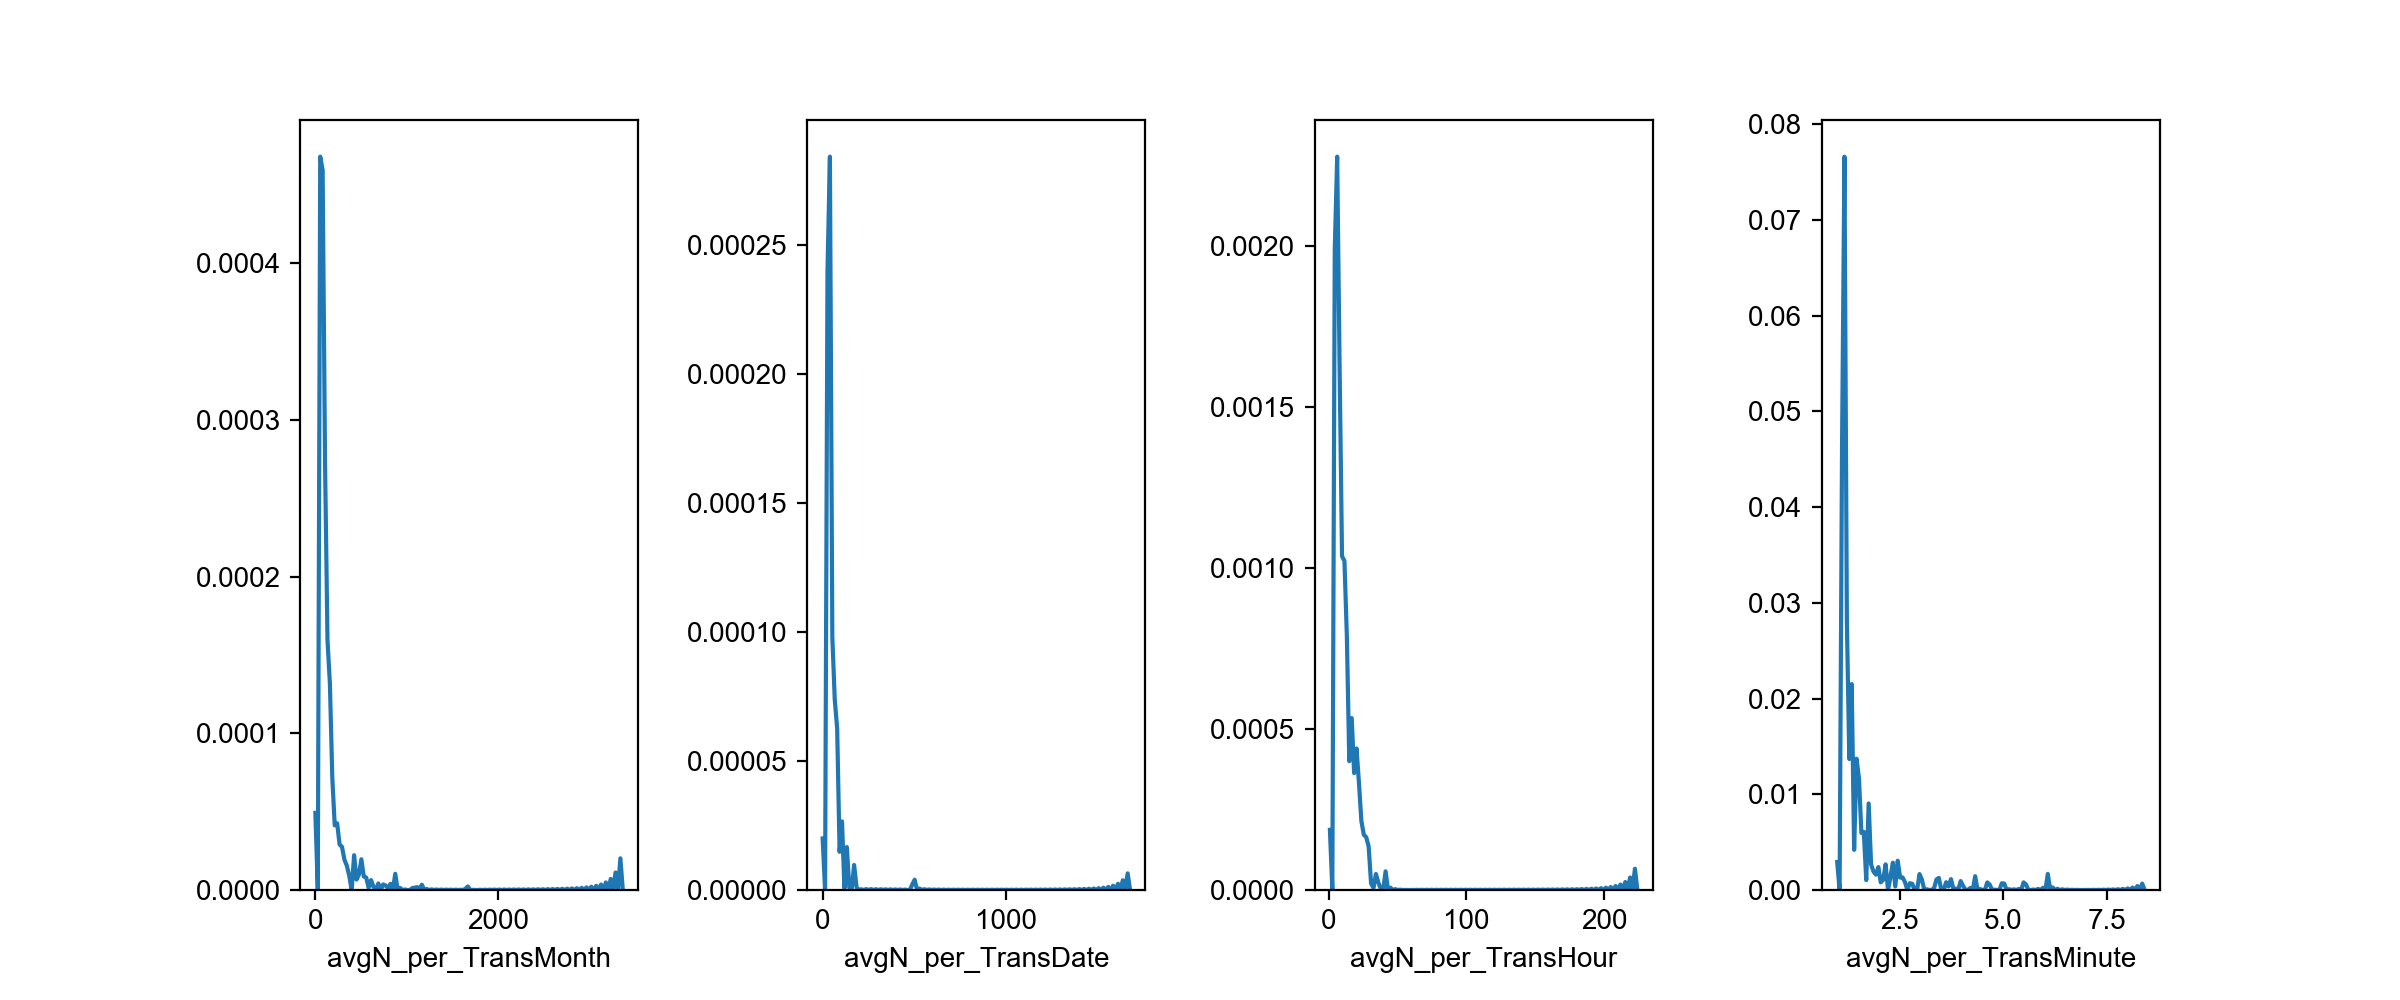

Index(['Oneday', 'Onetime', 'N', 'FirstTransDate', 'LastTransDate', 'Horizon',
       'densityoverH', '0.25_qt', '0.5_qt', '0.75_qt', 'lg_min', 'lg_max',
       'lg_mean', 'Nin2033', 'Nin2034', 'avgN_per_TransMonth',
       'avgN_per_TransDate', 'avgN_per_TransHour', 'avgN_per_TransMinute',
       'avgN_per_time', 'avg_lgvalue_per_transday', 'Q1', 'Q2', 'Q3', 'Q4',
       'Monday', 'Wednesday', 'Tuesday', 'Friday', 'Thursday', 'Sunday',
       'Saturday', 'sleep', 'prework', 'working', 'postwork', 'lg_range',
       '75_25_range', 'lg75_lg25_range', 'weekends', 'weekdays'],
      dtype='object')

In [14]:
plt.figure(figsize = (12,5))
n = 0
feature_to_display = ['avgN_per_TransMonth','avgN_per_TransDate','avgN_per_TransHour','avgN_per_TransMinute']
for x in feature_to_display:
    n += 1
    plt.subplot(1,len(feature_to_display),n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot(dfmerchant[x],bins = 50, hist = False)
    #plt.title('Distplot of {}'.format(x))
plt.show()

dfmerchant.columns

In [16]:
#**************** create feature interactions
allfeatures = ['0.25_qt', '0.5_qt', '0.75_qt', '75_25_range',
              'lg_min', 'lg_max','lg_mean','lg_range','lg75_lg25_range',
              'avgN_per_TransMonth','avgN_per_TransDate', 'avgN_per_TransHour','avgN_per_TransMinute', 'avgN_per_time',
              'Q1', 'Q2', 'Q3', 'Q4',
              #'month1','month2','month3','month4','month5','month6','month7','month8','month9','month10','month11','month12',
              'weekends', 'weekdays',
              'Monday', 'Wednesday', 'Tuesday', 'Friday','Thursday', 'Saturday', 'Sunday',
              #'hourbin1','hourbin2','hourbin3','hourbin4','hourbin5','hourbin6',
              #'hourbin7','hourbin8','hourbin9','hourbin10','hourbin11','hourbin12',
              'sleep', 'prework', 'working', 'postwork']

remainingfeatures = allfeatures
dfinteract = pd.DataFrame()
for i in allfeatures:
    remainingfeatures = [x for x in remainingfeatures if x != i]
    for j in remainingfeatures:
        dfinteract[i+'_'+j] = dfmerchant[i]*dfmerchant[j]
        
dffinal = pd.merge(dfmerchant, dfinteract, how = 'outer', left_index = True, right_index = True)

In [96]:
dffinal.columns

Index(['Oneday', 'Onetime', 'N', 'FirstTransDate', 'LastTransDate', 'Horizon',
       'densityoverH', '0.25_qt', '0.5_qt', '0.75_qt',
       ...
       'Sunday_prework', 'Sunday_working', 'Sunday_postwork', 'sleep_prework',
       'sleep_working', 'sleep_postwork', 'prework_working',
       'prework_postwork', 'working_postwork', 'layer1'],
      dtype='object', length=507)

In [17]:
group1_1 = ['0.25_qt', '0.5_qt', '0.75_qt','75_25_range']
group1_2 = ['lg_min', 'lg_max','lg_mean','lg_range','lg_75_25_range','lg75_lg25_range']
group2   = ['avglgN_per_TransMonth','avglgN_per_TransDate', 'avglgN_per_TransHour','avglgN_per_TransMinute', 'avglgN_per_time']
group3_1 = ['Q1', 'Q2', 'Q3', 'Q4']
#group3_2 = ['month1','month2','month3','month4','month5','month6','month7','month8','month9','month10','month11','month12']
group4_1 = ['weekends', 'weekdays']
#group4_2 = ['Monday', 'Wednesday', 'Tuesday', 'Friday','Thursday', 'Saturday', 'Sunday']
#group5_1 = ['hourbin1','hourbin2','hourbin3','hourbin4','hourbin5','hourbin6',
#            'hourbin7','hourbin8','hourbin9','hourbin10','hourbin11','hourbin12']
group5_2 = ['sleep', 'prework', 'working', 'postwork']

In [105]:
#************ Selected desired features
features_selected = [#'75_25_range',
                     #'lg_min','lg75_lg25_range',
                     #'avgN_per_TransMonth',
                     #'Q3','Q4',
                     # 'month1','month2','month3','month4','month5','month6','month7','month8','month9','month10','month11','month12'
                     'weekends','weekdays',
                     'postwork'
                     #'hourbin1','hourbin5','hourbin6',
                     #'hourbin7','hourbin8','hourbin9','hourbin10','hourbin11','hourbin12'
                    ]
X = dffinal[features_selected]
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print(vif)

interact_selected = list()
remaining = features_selected
for i in features_selected:
    remaining = [x for x in remaining if x != i]
    #print(remaining)
    for j in remaining:
        interact_selected.append(i+'_'+j)

features = features_selected + interact_selected

violionfeature1 = ['lg_min','lg75_lg25_range']
violionfeature2 = ['avgN_per_TransMonth']
violionfeature3 = ['Q3','Q4']
violionfeature4 = ['weekends','weekdays']
violionfeature5 = ['postwork']
violionfeature6 = ['hourbin9','hourbin10','hourbin11','hourbin12']

features

                 0
weekends  1.596532
weekdays  2.436374
postwork  1.016058


['weekends',
 'weekdays',
 'postwork',
 'weekends_weekdays',
 'weekends_postwork',
 'weekdays_postwork']

In [106]:
#************* Setup dataset features to be used
X1 = dffinal[features]
#print(X1.head())
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X1 = scaler.fit_transform(X1)
X1 = pd.DataFrame(X1)
X1.rename(columns = dict(zip(list(X1.columns),features)), inplace = True)
#print(X1.columns)
X1.head()

,weekends,weekdays,postwork,weekends_weekdays,weekends_postwork,weekdays_postwork
0,0.00,1.00,1.0,0.00,0.000,1.000
1,0.25,0.75,0.5,0.75,0.125,0.375
2,0.00,1.00,0.0,0.00,0.000,0.000
3,0.00,1.00,1.0,0.00,0.000,1.000
4,0.00,1.00,0.0,0.00,0.000,0.000


<IPython.core.display.Javascript object>


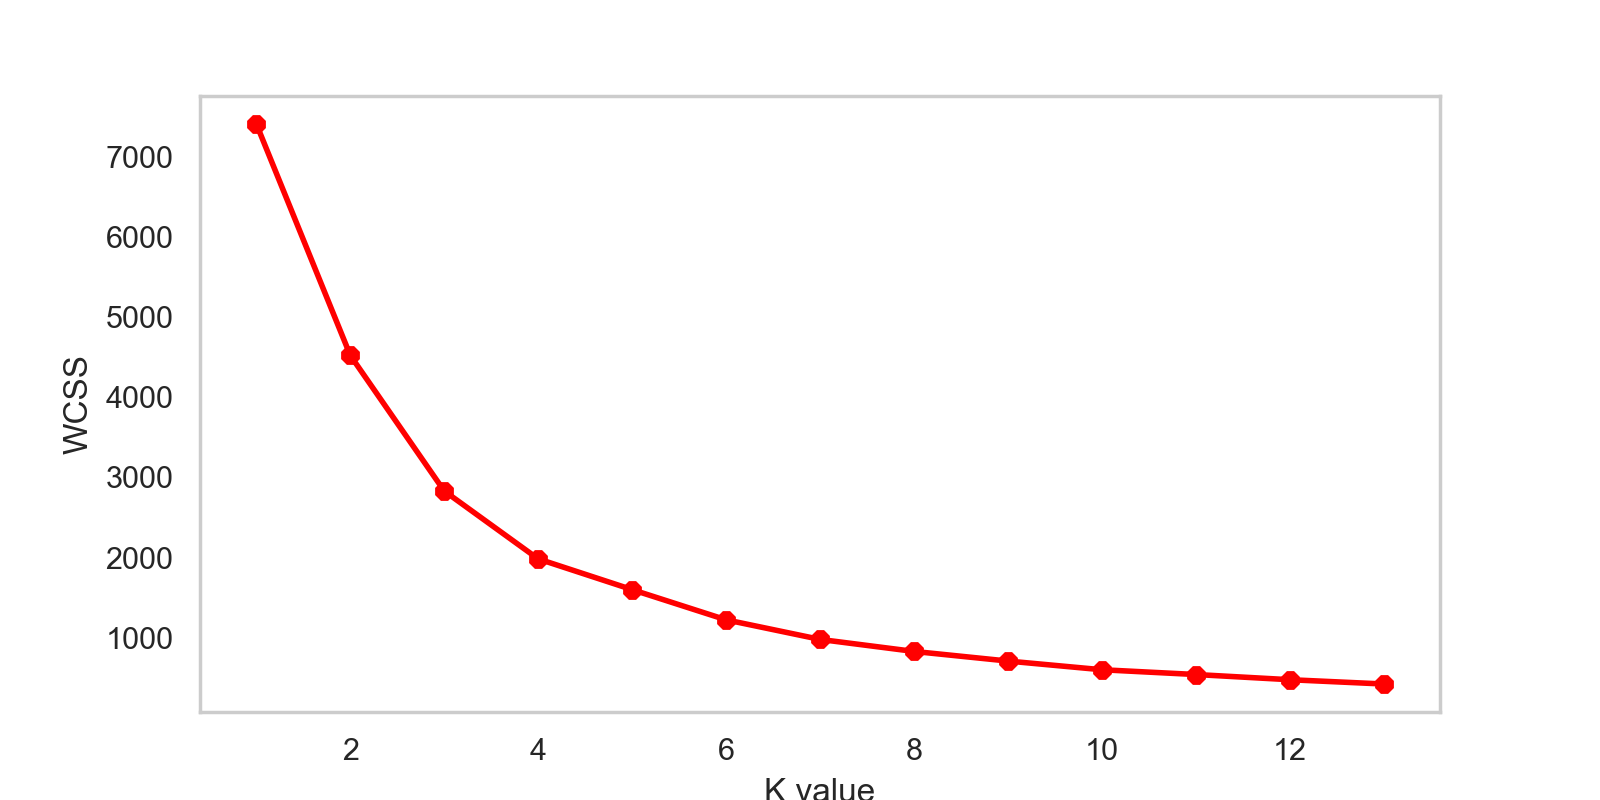

In [107]:
#********** Kmeans - To select # of clusters
from sklearn.cluster import KMeans
wcss = list()
for k in range(1,14):
    kmeans = KMeans(n_clusters=k, init = 'k-means++')
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize = (8,4))
plt.grid()
plt.plot(range(1,14),wcss, linewidth=2, color = 'red', marker = '8')
plt.xlabel('K value')
plt.ylabel('WCSS')
plt.show()

In [108]:
#********** Kmeans - fit cluster
n = 4
class_labels = ['cluster1', 'cluster2','cluster3', 'cluster4', 'cluster5']

kmeans = KMeans(n_clusters = n, init = 'k-means++',random_state = 0)
label = kmeans.fit_predict(X1)

3    0.095882
0    0.660024
1    0.139433
2    0.104662
dtype: float64


<IPython.core.display.Javascript object>


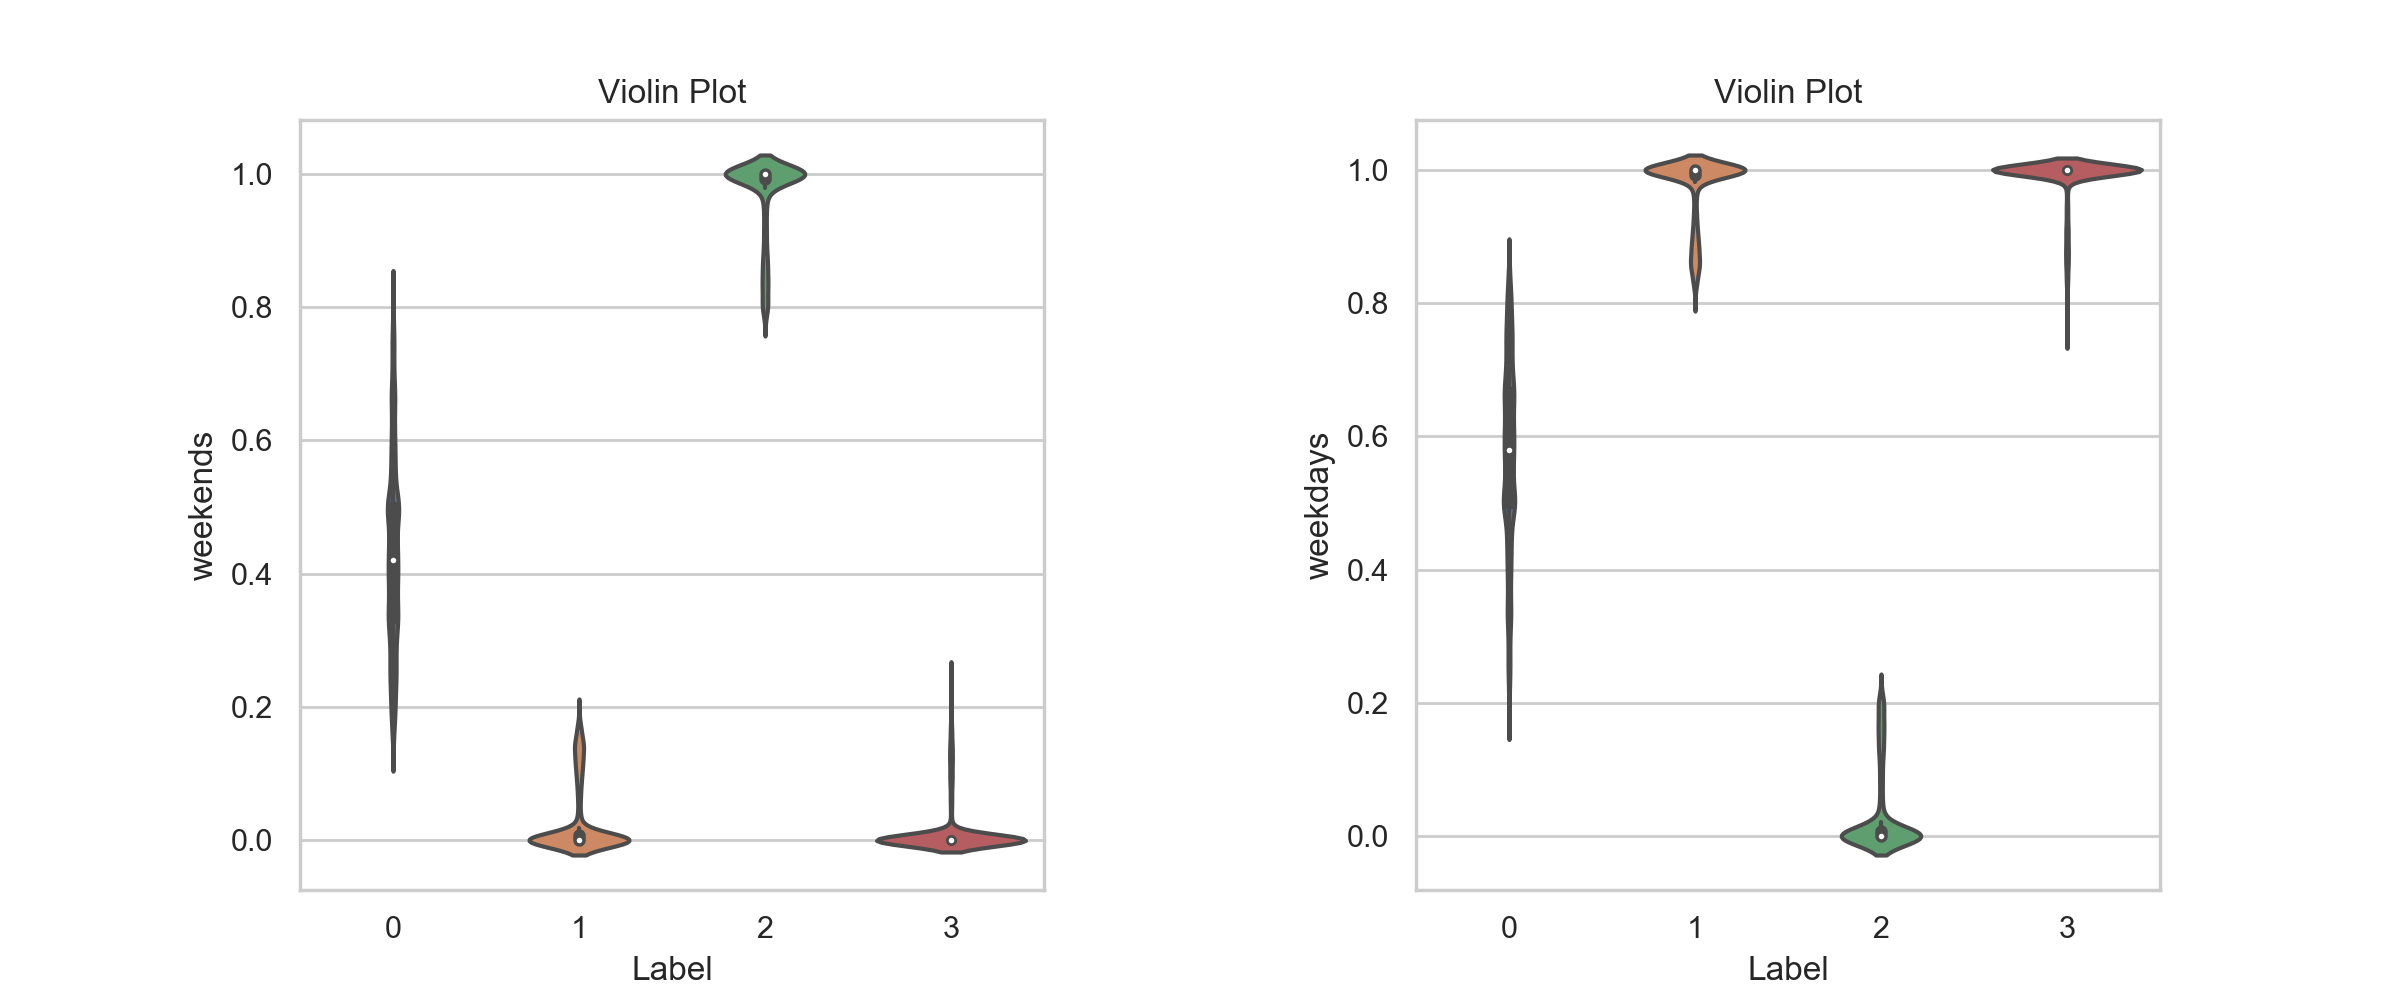

<IPython.core.display.Javascript object>


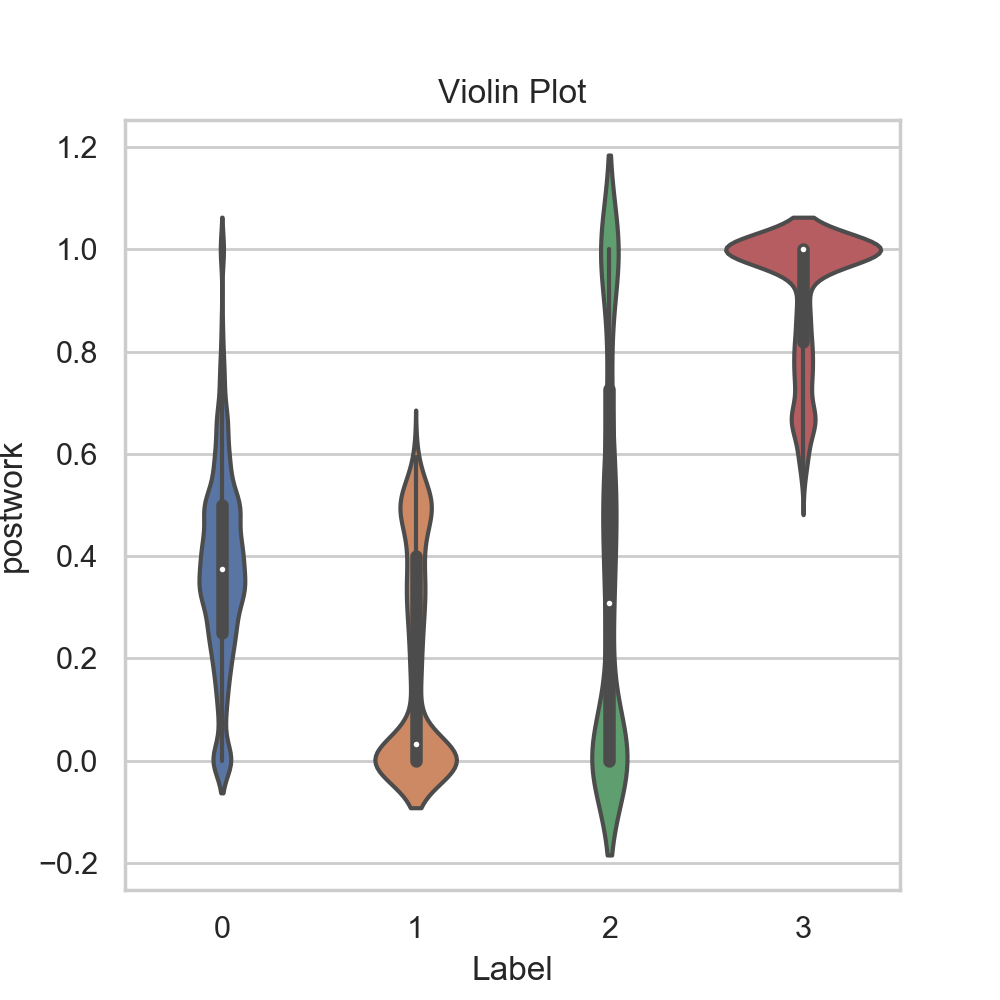

In [109]:
clusterpct(n, X1, label)
#violionplot(violionfeature1,X1,label,(12,4))
#violionplot(violionfeature2,X1,label, (12,5))
#violionplot(violionfeature3,X1,label, (12,5))
violionplot(violionfeature4,X1,label, (12,5))
violionplot(violionfeature5,X1,label, (5,5))
#violionplot(violionfeature6,X1,label, (16,5))

In [110]:
layer1_labels = label  # amount and frequency ['lg_min','lg75_lg25_range','avgN_per_TransDate',]
cols = list(X1.columns)
cols.remove('Label')
centers = pd.DataFrame(kmeans.cluster_centers_, columns = cols)

In [111]:
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = features)

,weekends,weekdays,postwork,weekends_weekdays,weekends_postwork,weekdays_postwork
0,0.427867,0.572133,0.374928,0.224783,0.158941,0.215986
1,0.026106,0.973894,0.186144,0.022831,0.008354,0.177791
2,0.969840,0.030160,0.380895,0.025546,0.368358,0.012537
3,0.010863,0.989137,0.913946,0.009326,0.008729,0.905217


In [112]:
dffinal['layer1'] = layer1_labels
df1 = dffinal[['weekends','weekdays','postwork','layer1']]

segmentation_results = dffinal['layer1']

In [118]:
df1.groupby('layer1').describe().to_csv('layer1stats.csv')

In [122]:
pd.DataFrame(segmentation_results).to_csv('segmentation_results.csv')